In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import sys
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [4]:
def train_test_split_data(df, target_column):
    X = df.loc[:, df.columns!= target_column]
    Y = df.loc[:, df.columns == target_column]

    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=45, stratify= Y)
    return X_train, X_test, y_train, y_test

In [5]:
def basic_classifier(X_train,y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

In [6]:
def predict_test(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

def predict_proba_test(model, X_test):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [7]:
def get_metrics(y_test, y_pred, y_pred_proba):
    d = {
        'accuracy_score' : accuracy_score(y_test, y_pred),
        'precision' : precision_score(y_test, y_pred, average='micro'),
        'recall' : recall_score(y_test, y_pred, average= 'micro'),
        'entropy' : log_loss(y_test, y_pred_proba)
    }
    return d

In [8]:
def create_roc_auc_curve(clf, X_data, y_data):
    RocCurveDisplay.from_estimator(clf, X_data, y_data)
    plt.savefig('roc_auc_curve2.png')
def create_confusion_matrix_plot(clf, X_test, y_test):
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    plt.savefig('confusion_matrix2.png')

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/iris.csv')
df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
target_column = 'class'
X_train, X_test, y_train, y_test =train_test_split_data(df, target_column)

In [11]:
X_train.head()

,sepal-length,sepal-width,petal-length,petal-width
7,5.0,3.4,1.5,0.2
105,7.6,3.0,6.6,2.1
129,7.2,3.0,5.8,1.6
98,5.1,2.5,3.0,1.1
140,6.7,3.1,5.6,2.4


In [12]:
model = basic_classifier(X_train, y_train)
model

c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [11]:
y_pred = predict_test(model, X_test)
y_pred_proba = predict_proba_test(model, X_test)

In [12]:
y_pred

array(['Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor',
       'Iris-setosa', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor'], dtype=object)

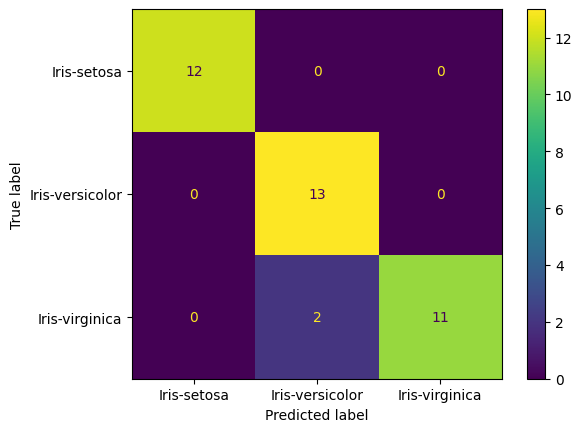

In [13]:
create_confusion_matrix_plot(model, X_test, y_test)

In [14]:
all_metrics = get_metrics(y_test, y_pred, y_pred_proba)

In [15]:
all_metrics

{'accuracy_score': 0.9473684210526315,
 'precision': 0.9473684210526315,
 'recall': 0.9473684210526315,
 'entropy': 0.1550744441696236}

## MLFLOW PART

In [16]:
def create__mlflow_experiment(experiment_name, run_name, model, all_metrics, 
                              confusion_matrix_path = None, roc_auc_path=None, run_params=None):
    
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):

        if not run_params == None:
            for params in run_params:
                mlflow.log_param(params, run_params[params])
        
        for metrics in all_metrics:
            mlflow.log_metric(metrics, all_metrics[metrics])

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, "Confusion Matrix")
        
        if not roc_auc_path == None:
            mlflow.log_artifact(roc_auc_path, "ROC AUC Path")

        mlflow.sklearn.log_model(model, 'model')
        mlflow.set_tags({"tag1":"IRIS DATASET" , "tag2":"Logisitic Regression", "tag3": "One vs rest all"})

    print(f'Run - {run_name}, is logged under experiment - {experiment_name}')
        



## START MLFLOW SERVER USING SQLITE 
- AS TO AVAIL MODEL REGISTRY FUNCTIONALITY WE NEED A DATABASE , FILE SYSTEM WONT WORK 
- cmd - mlflow ui will not work
- cmd - mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000 (will work)

In [18]:
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000
from datetime import datetime
experiment_name = 'iris_classifier_'+ str(datetime.now().strftime("%d-%m-%y"))
run_name = 'predict_flower_'+ str(datetime.now().strftime("%d-%m-%y"))
create__mlflow_experiment(experiment_name, run_name, model, all_metrics, 'confusion_matrix2.png')

2024/03/21 19:55:06 INFO mlflow.tracking.fluent: Experiment with name 'iris_classifier_21-03-24' does not exist. Creating a new experiment.


Run - predict_flower_21-03-24, is logged under experiment - iris_classifier_21-03-24


## PREDICTING USING CODE AVAILBLE IN UI

In [19]:
logged_model = 'runs:/c054169226f641559046e11ff7013cb9/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model.predict(pd.DataFrame(X_test))

array(['Iris-versicolor', 'Iris-versicolor', 'Iris-virginica',
       'Iris-setosa', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor',
       'Iris-setosa', 'Iris-virginica', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor'], dtype=object)

## REGISTERING MODEL 
- We need to use a hyperparamater while logging model -> registered_model_name = 'model_name'

In [20]:
def create__mlflow_experiment(experiment_name, run_name, model, all_metrics, 
                              confusion_matrix_path = None, roc_auc_path=None, run_params=None):
    
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=run_name):

        if not run_params == None:
            for params in run_params:
                mlflow.log_param(params, run_params[params])
        
        for metrics in all_metrics:
            mlflow.log_metric(metrics, all_metrics[metrics])

        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, "Confusion Matrix")
        
        if not roc_auc_path == None:
            mlflow.log_artifact(roc_auc_path, "ROC AUC Path")

        mlflow.sklearn.log_model(model, 'model', registered_model_name='IRIS_Classifier')
        mlflow.set_tags({"tag1":"IRIS DATASET" , "tag2":"Logisitic Regression", "tag3": "One vs rest all"})

    print(f'Run - {run_name}, is logged under experiment - {experiment_name}')
        

In [21]:
experiment_name = 'iris_classifier_1'#+ str(datetime.now().strftime("%d-%m-%y"))
run_name = 'predict_flower_1'#+ str(datetime.now().strftime("%d-%m-%y"))
create__mlflow_experiment(experiment_name, run_name, model, all_metrics, 'confusion_matrix2.png')

c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'IRIS_Classifier' already exists. Creating a new version of this model...
2024/03/21 19:56:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: IRIS_Classifier, version 2


Run - predict_flower_1, is logged under experiment - iris_classifier_1


Created version '2' of model 'IRIS_Classifier'.


## METHOD -2 -> Register model on MLFLOW
- use mlflow.register_model() method, inside it we need to pass the run id , to make sure which model to register 

In [22]:
with mlflow.start_run(run_name = "method_2_run"):
    result = mlflow.register_model(
        "runs:/c054169226f641559046e11ff7013cb9/model",
        "iris_classifier_with_method2"
    )

Successfully registered model 'iris_classifier_with_method2'.
2024/03/21 19:58:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_classifier_with_method2, version 1
Created version '1' of model 'iris_classifier_with_method2'.


## METHOD 3 -> Register model on mlflow using create_registered_model()
- We will create a skeleton model with just model name and then link the required model present in an experiment to that skeleton using run_id

In [23]:
client = mlflow.tracking.MlflowClient()
client.create_registered_model("iris_classifier_method3")

<RegisteredModel: aliases={}, creation_timestamp=1711031678582, description='', last_updated_timestamp=1711031678582, latest_versions=[], name='iris_classifier_method3', tags={}>

In [30]:
client = mlflow.tracking.MlflowClient()
result = client.create_model_version(
    name = "iris_classifier_method3",
    source= 'artifacts/1/076633fc0bca48f28c5b7fa0a503d68a/artifacts/model',
    run_id= '076633fc0bca48f28c5b7fa0a503d68a'
)

2024/03/21 20:19:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: iris_classifier_method3, version 2


## USING MODEL FROM MODEL REGISTRY for prediction 
- We can use mlflow.pyfunc.load_model / mlflow.sklearn.load_model , to load the model and do the predictions

In [33]:
import mlflow.pyfunc

model_name = "iris_classifier_method3"
version = 2

fetched_model = mlflow.pyfunc.load_model(
    model_uri= f"models:/{model_name}/{version}"
)

print(fetched_model.predict(X_test))

['Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-virginica'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-setosa' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor']


## TRANSITION A MODEL FROM DEFAULT TO PRODUCTION 
- To do this , we need transition_model_version_stage() and in parameter we need to pass the name of model , the version and name of stage - 'production'

In [34]:
client.transition_model_version_stage(
    name = 'iris_classifier_method3',
    version=2,
    stage= 'Production'
)

C:\Users\sriva\AppData\Local\Temp\ipykernel_4564\2293294121.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1711032549932, current_stage='Production', description='', last_updated_timestamp=1711033734555, name='iris_classifier_method3', run_id='076633fc0bca48f28c5b7fa0a503d68a', run_link='', source='artifacts/1/076633fc0bca48f28c5b7fa0a503d68a/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>

In [43]:
prod_model = mlflow.pyfunc.load_model(
    model_uri= f'models:/iris_classifier_method3/Production'
)
print(prod_model.predict(X_test))

c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.1/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


['Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-virginica'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-setosa' 'Iris-virginica' 'Iris-virginica'
 'Iris-virginica' 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa'
 'Iris-setosa' 'Iris-versicolor' 'Iris-versicolor' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-versicolor' 'Iris-setosa'
 'Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-versicolor']


## SERVING A MODEL IN MLFLOW
- Once you have decided which model is fine , you can use that model and serve it . and using api request we can predict from that model

STEPS -
1. Make sure the tracking URI is set to 5000 . check it using mlflow.get_tracking_uri()
set it using mlflow.set_tracking_uri('http://localhost:5000')

2. Once it has been set verify in environment variable if it has been set properly or not.

3. start the server normally .

4. use below command on command prompt to serve particular model on port 1234 - 
- in place of models , write your model name , inplace of production paste your stage 

- cmd - mlflow models serve --model-uri models:/iris-classifier/Production -p 1234 --no-conda

5. If above command doesnt work then try adding actual complete path of the model.

- cmd - >mlflow models serve -m file:///C:/Users/sriva/OneDrive/Desktop/MLflow/artifacts/1/076633fc0bca48f28c5b7fa0a503d68a/artifacts/model -p 1234 --no-conda

5. finally once the model is serving use below command to do prediction - 

endpoint = "http://localhost:1234/invocations"

In [40]:
mlflow.set_tracking_uri('http://localhost:5000')

In [41]:
mlflow.get_registry_uri()

'http://localhost:5000'

In [2]:
import requests

inference_request = {
        "dataframe_records": [[6.7,3.3,5.7,2.1]]
}

endpoint = "http://localhost:1234/invocations"

response = requests.post(endpoint, json=inference_request)

print(response.text)

{"predictions": ["Iris-virginica"]}


In [14]:
# import joblib
# joblib.dump(model, "LogisticRegression.pkl")

['LogisticRegression.pkl']